In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 150
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 't2m', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

Day  wind_10m  specific_humidity     LW_down   SW_down  rainfall  \
7305  1/1/1999  4.987515           0.891843  183.786092  1.120906  0.700735   
7306  1/2/1999  5.075952           0.905535  183.851814  1.193514  0.712730   
7307  1/3/1999  4.931520           0.911672  184.426913  1.263909  0.677339   
7308  1/4/1999  4.761644           0.911301  187.528326  1.269229  0.824016   
7309  1/5/1999  4.739850           0.901353  187.326709  1.552208  0.926681   

      snowfall   sosaline         sst         t2m  surface_pressure  \
7305  0.501109  33.316996  273.467869  250.884060        985.112721   
7306  0.482221  33.316996  273.453826  250.359328        984.092282   
7307  0.480718  33.316996  273.454385  250.327500        982.300080   
7308  0.697950  33.316996  273.459797  249.905730        983.250565   
7309  0.835868  33.316996  273.463975  250.254873        984.247389   

      sea_ice_extent  
7305        13823248  
7306        13885522  
7307        13884279  
7308        13912624  
7309        13890148

In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

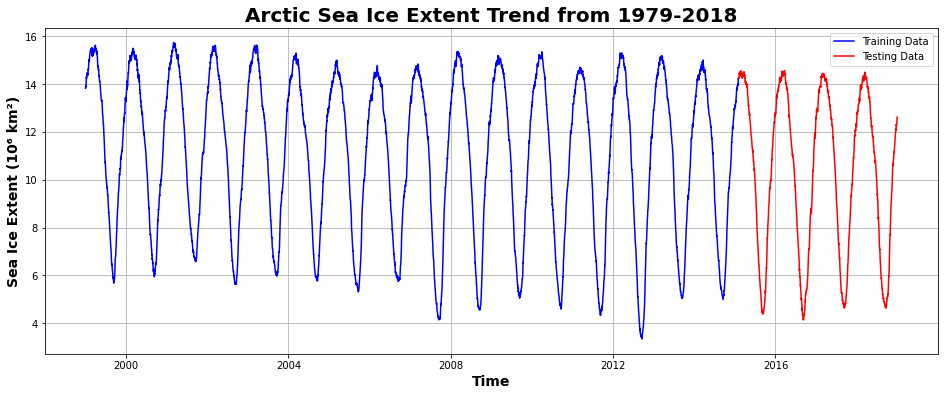

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,729
Trainable params: 121,729
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0240 - mae: 0.1136 - mse: 0.0240

81/81 [==============================] - 9s 18ms/step - loss: 0.0236 - mae: 0.1125 - mse: 0.0236 - val_loss: 0.0031 - val_mae: 0.0408 - val_mse: 0.0031
Epoch 2/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0078 - mae: 0.0705 - mse: 0.0078

81/81 [==============================] - 1s 7ms/step - loss: 0.0077 - mae: 0.0699 - mse: 0.0077 - val_loss: 0.0036 - val_mae: 0.0482 - val_mse: 0.0036
Epoch 3/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0065 - mae: 0.0637 - mse: 0.0065

81/81 [==============================] - 1s 8ms/step - loss: 0.0064 - mae: 0.0634 - mse: 0.0064 - val_loss: 0.0033 - val_mae: 0.0381 - val_mse: 0.0033
Epoch 4/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0052 - mae: 0.0571 - mse: 0.0052

81/81 [==============================] - 1s 7ms/step - loss: 0.0052 - mae: 0.0568 - mse: 0.0052 - val_loss: 0.0021 - val_mae: 0.0359 - val_mse: 0.0021
Epoch 5/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0047 - mae: 0.0548 - mse: 0.0047

81/81 [==============================] - 1s 7ms/step - loss: 0.0047 - mae: 0.0551 - mse: 0.0047 - val_loss: 0.0019 - val_mae: 0.0294 - val_mse: 0.0019
Epoch 6/100
79/81 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0516 - mse: 0.0043

81/81 [==============================] - 1s 7ms/step - loss: 0.0043 - mae: 0.0516 - mse: 0.0043 - val_loss: 0.0037 - val_mae: 0.0412 - val_mse: 0.0037
Epoch 7/100
80/81 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0497 - mse: 0.0040

81/81 [==============================] - 1s 7ms/step - loss: 0.0039 - mae: 0.0497 - mse: 0.0039 - val_loss: 0.0035 - val_mae: 0.0365 - val_mse: 0.0035
Epoch 8/100
79/81 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0478 - mse: 0.0037

81/81 [==============================] - 1s 7ms/step - loss: 0.0037 - mae: 0.0478 - mse: 0.0037 - val_loss: 0.0028 - val_mae: 0.0364 - val_mse: 0.0028
Epoch 9/100
79/81 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0478 - mse: 0.0037

81/81 [==============================] - 1s 8ms/step - loss: 0.0037 - mae: 0.0477 - mse: 0.0037 - val_loss: 0.0016 - val_mae: 0.0343 - val_mse: 0.0016
Epoch 10/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0039 - mae: 0.0491 - mse: 0.0039

81/81 [==============================] - 1s 7ms/step - loss: 0.0039 - mae: 0.0490 - mse: 0.0039 - val_loss: 0.0028 - val_mae: 0.0359 - val_mse: 0.0028
Epoch 11/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0033 - mae: 0.0448 - mse: 0.0033

81/81 [==============================] - 1s 7ms/step - loss: 0.0033 - mae: 0.0448 - mse: 0.0033 - val_loss: 0.0011 - val_mae: 0.0255 - val_mse: 0.0011
Epoch 12/100
73/81 [==========================>...] - ETA: 0s - loss: 0.0032 - mae: 0.0445 - mse: 0.0032

81/81 [==============================] - 1s 7ms/step - loss: 0.0031 - mae: 0.0439 - mse: 0.0031 - val_loss: 0.0013 - val_mae: 0.0317 - val_mse: 0.0013
Epoch 13/100
81/81 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0442 - mse: 0.0032

81/81 [==============================] - 1s 7ms/step - loss: 0.0032 - mae: 0.0442 - mse: 0.0032 - val_loss: 0.0023 - val_mae: 0.0368 - val_mse: 0.0023
Epoch 14/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0030 - mae: 0.0426 - mse: 0.0030

81/81 [==============================] - 1s 7ms/step - loss: 0.0030 - mae: 0.0427 - mse: 0.0030 - val_loss: 0.0020 - val_mae: 0.0381 - val_mse: 0.0020
Epoch 15/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0032 - mae: 0.0441 - mse: 0.0032

81/81 [==============================] - 1s 7ms/step - loss: 0.0031 - mae: 0.0441 - mse: 0.0031 - val_loss: 0.0017 - val_mae: 0.0298 - val_mse: 0.0017
Epoch 16/100
80/81 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0399 - mse: 0.0026

81/81 [==============================] - 1s 7ms/step - loss: 0.0026 - mae: 0.0399 - mse: 0.0026 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011
Epoch 17/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0027 - mae: 0.0406 - mse: 0.0027

81/81 [==============================] - 1s 7ms/step - loss: 0.0027 - mae: 0.0408 - mse: 0.0027 - val_loss: 0.0023 - val_mae: 0.0384 - val_mse: 0.0023
Epoch 18/100
79/81 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0397 - mse: 0.0026

81/81 [==============================] - 1s 7ms/step - loss: 0.0025 - mae: 0.0396 - mse: 0.0025 - val_loss: 0.0011 - val_mae: 0.0244 - val_mse: 0.0011
Epoch 19/100
80/81 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0422 - mse: 0.0029

81/81 [==============================] - 1s 7ms/step - loss: 0.0029 - mae: 0.0422 - mse: 0.0029 - val_loss: 0.0011 - val_mae: 0.0267 - val_mse: 0.0011
Epoch 20/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0384 - mse: 0.0024

81/81 [==============================] - 1s 7ms/step - loss: 0.0025 - mae: 0.0385 - mse: 0.0025 - val_loss: 0.0019 - val_mae: 0.0313 - val_mse: 0.0019
Epoch 21/100
81/81 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0391 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0391 - mse: 0.0025 - val_loss: 0.0021 - val_mae: 0.0334 - val_mse: 0.0021
Epoch 22/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0382 - mse: 0.0025

81/81 [==============================] - 1s 7ms/step - loss: 0.0025 - mae: 0.0382 - mse: 0.0025 - val_loss: 0.0021 - val_mae: 0.0404 - val_mse: 0.0021
Epoch 23/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0376 - mse: 0.0023

81/81 [==============================] - 1s 7ms/step - loss: 0.0023 - mae: 0.0374 - mse: 0.0023 - val_loss: 0.0013 - val_mae: 0.0282 - val_mse: 0.0013
Epoch 24/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0377 - mse: 0.0024

81/81 [==============================] - 1s 7ms/step - loss: 0.0024 - mae: 0.0377 - mse: 0.0024 - val_loss: 0.0021 - val_mae: 0.0335 - val_mse: 0.0021
Epoch 25/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0381 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0382 - mse: 0.0025 - val_loss: 0.0010 - val_mae: 0.0261 - val_mse: 0.0010
Epoch 26/100
80/81 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0393 - mse: 0.0026

81/81 [==============================] - 1s 7ms/step - loss: 0.0026 - mae: 0.0393 - mse: 0.0026 - val_loss: 0.0011 - val_mae: 0.0276 - val_mse: 0.0011
Epoch 27/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0363 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0364 - mse: 0.0022 - val_loss: 0.0016 - val_mae: 0.0282 - val_mse: 0.0016
Epoch 28/100
80/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0361 - mse: 0.0021

81/81 [==============================] - 1s 11ms/step - loss: 0.0021 - mae: 0.0361 - mse: 0.0021 - val_loss: 0.0011 - val_mae: 0.0261 - val_mse: 0.0011
Epoch 29/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0352 - mse: 0.0021

81/81 [==============================] - 1s 11ms/step - loss: 0.0021 - mae: 0.0354 - mse: 0.0021 - val_loss: 0.0014 - val_mae: 0.0278 - val_mse: 0.0014
Epoch 30/100
79/81 [============================>.] - ETA: 0s - loss: 0.0023 - mae: 0.0376 - mse: 0.0023

81/81 [==============================] - 1s 10ms/step - loss: 0.0023 - mae: 0.0376 - mse: 0.0023 - val_loss: 0.0015 - val_mae: 0.0296 - val_mse: 0.0015
Epoch 31/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0356 - mse: 0.0021

81/81 [==============================] - 1s 7ms/step - loss: 0.0021 - mae: 0.0356 - mse: 0.0021 - val_loss: 0.0019 - val_mae: 0.0338 - val_mse: 0.0019
Epoch 32/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0354 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0354 - mse: 0.0021 - val_loss: 0.0012 - val_mae: 0.0277 - val_mse: 0.0012
Epoch 33/100
80/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0356 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0356 - mse: 0.0021 - val_loss: 0.0019 - val_mae: 0.0382 - val_mse: 0.0019
Epoch 34/100
80/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0357 - mse: 0.0021

81/81 [==============================] - 1s 7ms/step - loss: 0.0021 - mae: 0.0357 - mse: 0.0021 - val_loss: 0.0015 - val_mae: 0.0284 - val_mse: 0.0015
Epoch 35/100
81/81 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0340 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0340 - mse: 0.0019 - val_loss: 0.0016 - val_mae: 0.0309 - val_mse: 0.0016
Epoch 36/100
81/81 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0334 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0334 - mse: 0.0019 - val_loss: 0.0016 - val_mae: 0.0317 - val_mse: 0.0016
Epoch 37/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0340 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0340 - mse: 0.0019 - val_loss: 0.0024 - val_mae: 0.0400 - val_mse: 0.0024
Epoch 38/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0355 - mse: 0.0022

81/81 [==============================] - 1s 7ms/step - loss: 0.0022 - mae: 0.0355 - mse: 0.0022 - val_loss: 0.0019 - val_mae: 0.0362 - val_mse: 0.0019
Epoch 39/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0341 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0341 - mse: 0.0020 - val_loss: 0.0015 - val_mae: 0.0317 - val_mse: 0.0015
Epoch 40/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0343 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0342 - mse: 0.0020 - val_loss: 0.0016 - val_mae: 0.0309 - val_mse: 0.0016
Epoch 41/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0343 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0343 - mse: 0.0020 - val_loss: 0.0014 - val_mae: 0.0283 - val_mse: 0.0014
Epoch 42/100
80/81 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0355 - mse: 0.0022

81/81 [==============================] - 1s 7ms/step - loss: 0.0021 - mae: 0.0355 - mse: 0.0021 - val_loss: 0.0021 - val_mae: 0.0365 - val_mse: 0.0021
Epoch 43/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0334 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0336 - mse: 0.0019 - val_loss: 0.0016 - val_mae: 0.0310 - val_mse: 0.0016
Epoch 44/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0322 - mse: 0.0018

81/81 [==============================] - 1s 7ms/step - loss: 0.0018 - mae: 0.0323 - mse: 0.0018 - val_loss: 0.0017 - val_mae: 0.0319 - val_mse: 0.0017
Epoch 45/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020

81/81 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0346 - mse: 0.0020 - val_loss: 0.0017 - val_mae: 0.0322 - val_mse: 0.0017
Epoch 46/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0331 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0330 - mse: 0.0019 - val_loss: 0.0024 - val_mae: 0.0383 - val_mse: 0.0024
Epoch 47/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0337 - mse: 0.0019

81/81 [==============================] - 1s 7ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 0.0012 - val_mae: 0.0261 - val_mse: 0.0012
Epoch 48/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0321 - mse: 0.0017

81/81 [==============================] - 1s 7ms/step - loss: 0.0017 - mae: 0.0321 - mse: 0.0017 - val_loss: 0.0021 - val_mae: 0.0377 - val_mse: 0.0021
Epoch 49/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0332 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0330 - mse: 0.0019 - val_loss: 0.0014 - val_mae: 0.0257 - val_mse: 0.0014
Epoch 50/100
80/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0320 - mse: 0.0017

81/81 [==============================] - 1s 7ms/step - loss: 0.0017 - mae: 0.0321 - mse: 0.0017 - val_loss: 0.0022 - val_mae: 0.0373 - val_mse: 0.0022
Epoch 51/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0333 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0332 - mse: 0.0019 - val_loss: 0.0017 - val_mae: 0.0355 - val_mse: 0.0017
Epoch 52/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0325 - mse: 0.0018

81/81 [==============================] - 1s 7ms/step - loss: 0.0018 - mae: 0.0324 - mse: 0.0018 - val_loss: 0.0016 - val_mae: 0.0319 - val_mse: 0.0016
Epoch 53/100
81/81 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

81/81 [==============================] - 1s 7ms/step - loss: 0.0015 - mae: 0.0301 - mse: 0.0015 - val_loss: 0.0018 - val_mae: 0.0300 - val_mse: 0.0018
Epoch 54/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0305 - mse: 0.0016

81/81 [==============================] - 1s 7ms/step - loss: 0.0016 - mae: 0.0305 - mse: 0.0016 - val_loss: 0.0015 - val_mae: 0.0286 - val_mse: 0.0015
Epoch 55/100
81/81 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0323 - mse: 0.0017

81/81 [==============================] - 1s 13ms/step - loss: 0.0017 - mae: 0.0323 - mse: 0.0017 - val_loss: 0.0024 - val_mae: 0.0385 - val_mse: 0.0024
Epoch 56/100
81/81 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0326 - mse: 0.0018

81/81 [==============================] - 1s 10ms/step - loss: 0.0018 - mae: 0.0326 - mse: 0.0018 - val_loss: 0.0022 - val_mae: 0.0355 - val_mse: 0.0022
Epoch 57/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0300 - mse: 0.0015

81/81 [==============================] - 1s 12ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0021 - val_mae: 0.0342 - val_mse: 0.0021
Epoch 58/100
79/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0313 - mse: 0.0017

81/81 [==============================] - 1s 12ms/step - loss: 0.0017 - mae: 0.0313 - mse: 0.0017 - val_loss: 0.0022 - val_mae: 0.0379 - val_mse: 0.0022
Epoch 59/100
81/81 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

81/81 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0289 - mse: 0.0014 - val_loss: 0.0016 - val_mae: 0.0282 - val_mse: 0.0016
Epoch 60/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0294 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0293 - mse: 0.0014 - val_loss: 0.0016 - val_mae: 0.0313 - val_mse: 0.0016
Epoch 61/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0284 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0285 - mse: 0.0013 - val_loss: 0.0022 - val_mae: 0.0356 - val_mse: 0.0022
Epoch 62/100
80/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 0.0026 - val_mae: 0.0375 - val_mse: 0.0026
Epoch 63/100
81/81 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0285 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0285 - mse: 0.0014 - val_loss: 0.0019 - val_mae: 0.0341 - val_mse: 0.0019
Epoch 64/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0290 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0290 - mse: 0.0014 - val_loss: 0.0018 - val_mae: 0.0348 - val_mse: 0.0018
Epoch 65/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0281 - mse: 0.0013 - val_loss: 0.0020 - val_mae: 0.0345 - val_mse: 0.0020
Epoch 66/100
80/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0284 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0285 - mse: 0.0013 - val_loss: 0.0021 - val_mae: 0.0358 - val_mse: 0.0021
Epoch 67/100
81/81 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0285 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0285 - mse: 0.0014 - val_loss: 0.0028 - val_mae: 0.0405 - val_mse: 0.0028
Epoch 68/100
80/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

81/81 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 0.0019 - val_mae: 0.0335 - val_mse: 0.0019
Epoch 69/100
79/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

81/81 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 0.0027 - val_mae: 0.0425 - val_mse: 0.0027
Epoch 70/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - val_loss: 0.0019 - val_mae: 0.0385 - val_mse: 0.0019
Epoch 71/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0287 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0287 - mse: 0.0013 - val_loss: 0.0016 - val_mae: 0.0319 - val_mse: 0.0016
Epoch 72/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

81/81 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0042 - val_mae: 0.0505 - val_mse: 0.0042
Epoch 73/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0288 - mse: 0.0014

81/81 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0285 - mse: 0.0014 - val_loss: 0.0015 - val_mae: 0.0301 - val_mse: 0.0015
Epoch 74/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0267 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0267 - mse: 0.0012 - val_loss: 0.0014 - val_mae: 0.0300 - val_mse: 0.0014
Epoch 75/100
73/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0255 - mse: 0.0010

81/81 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0278 - val_mse: 0.0012
Epoch 76/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0021 - val_mae: 0.0381 - val_mse: 0.0021
Epoch 77/100
80/81 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0252 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0040 - val_mae: 0.0514 - val_mse: 0.0040
Epoch 78/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0024 - val_mae: 0.0396 - val_mse: 0.0024
Epoch 79/100
80/81 [============================>.] - ETA: 0s - loss: 9.8794e-04 - mae: 0.0246 - mse: 9.8794e-04

81/81 [==============================] - 1s 7ms/step - loss: 9.8881e-04 - mae: 0.0246 - mse: 9.8881e-04 - val_loss: 0.0028 - val_mae: 0.0420 - val_mse: 0.0028
Epoch 80/100
79/81 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0246 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0246 - mse: 0.0010 - val_loss: 0.0020 - val_mae: 0.0378 - val_mse: 0.0020
Epoch 81/100
80/81 [============================>.] - ETA: 0s - loss: 9.7381e-04 - mae: 0.0242 - mse: 9.7381e-04

81/81 [==============================] - 1s 7ms/step - loss: 9.7550e-04 - mae: 0.0242 - mse: 9.7550e-04 - val_loss: 0.0025 - val_mae: 0.0411 - val_mse: 0.0025
Epoch 82/100
80/81 [============================>.] - ETA: 0s - loss: 9.6131e-04 - mae: 0.0241 - mse: 9.6131e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.6082e-04 - mae: 0.0241 - mse: 9.6082e-04 - val_loss: 0.0017 - val_mae: 0.0343 - val_mse: 0.0017
Epoch 83/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010

81/81 [==============================] - 1s 7ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0022 - val_mae: 0.0349 - val_mse: 0.0022
Epoch 84/100
80/81 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0266 - mse: 0.0012

81/81 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0266 - mse: 0.0012 - val_loss: 0.0019 - val_mae: 0.0338 - val_mse: 0.0019
Epoch 85/100
74/81 [==========================>...] - ETA: 0s - loss: 8.9416e-04 - mae: 0.0232 - mse: 8.9416e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.8961e-04 - mae: 0.0233 - mse: 8.8961e-04 - val_loss: 0.0024 - val_mae: 0.0371 - val_mse: 0.0024
Epoch 86/100
80/81 [============================>.] - ETA: 0s - loss: 9.2358e-04 - mae: 0.0237 - mse: 9.2358e-04

81/81 [==============================] - 1s 7ms/step - loss: 9.2276e-04 - mae: 0.0237 - mse: 9.2276e-04 - val_loss: 0.0020 - val_mae: 0.0364 - val_mse: 0.0020
Epoch 87/100
80/81 [============================>.] - ETA: 0s - loss: 8.5904e-04 - mae: 0.0230 - mse: 8.5904e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.6028e-04 - mae: 0.0230 - mse: 8.6028e-04 - val_loss: 0.0026 - val_mae: 0.0393 - val_mse: 0.0026
Epoch 88/100
80/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0273 - mse: 0.0013

81/81 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0272 - mse: 0.0013 - val_loss: 0.0022 - val_mae: 0.0375 - val_mse: 0.0022
Epoch 89/100
81/81 [==============================] - ETA: 0s - loss: 8.3204e-04 - mae: 0.0225 - mse: 8.3204e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.3204e-04 - mae: 0.0225 - mse: 8.3204e-04 - val_loss: 0.0023 - val_mae: 0.0396 - val_mse: 0.0023
Epoch 90/100
75/81 [==========================>...] - ETA: 0s - loss: 7.5535e-04 - mae: 0.0216 - mse: 7.5535e-04

81/81 [==============================] - 1s 7ms/step - loss: 7.5845e-04 - mae: 0.0216 - mse: 7.5845e-04 - val_loss: 0.0026 - val_mae: 0.0427 - val_mse: 0.0026
Epoch 91/100
79/81 [============================>.] - ETA: 0s - loss: 7.9724e-04 - mae: 0.0220 - mse: 7.9724e-04

81/81 [==============================] - 1s 7ms/step - loss: 7.9710e-04 - mae: 0.0220 - mse: 7.9710e-04 - val_loss: 0.0021 - val_mae: 0.0356 - val_mse: 0.0021
Epoch 92/100
74/81 [==========================>...] - ETA: 0s - loss: 8.3251e-04 - mae: 0.0223 - mse: 8.3251e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.4281e-04 - mae: 0.0225 - mse: 8.4281e-04 - val_loss: 0.0026 - val_mae: 0.0389 - val_mse: 0.0026
Epoch 93/100
79/81 [============================>.] - ETA: 0s - loss: 8.5098e-04 - mae: 0.0227 - mse: 8.5098e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.4675e-04 - mae: 0.0226 - mse: 8.4675e-04 - val_loss: 0.0022 - val_mae: 0.0372 - val_mse: 0.0022
Epoch 94/100
73/81 [==========================>...] - ETA: 0s - loss: 7.9749e-04 - mae: 0.0220 - mse: 7.9749e-04

81/81 [==============================] - 1s 7ms/step - loss: 8.0757e-04 - mae: 0.0221 - mse: 8.0757e-04 - val_loss: 0.0021 - val_mae: 0.0365 - val_mse: 0.0021
Epoch 95/100
79/81 [============================>.] - ETA: 0s - loss: 8.9050e-04 - mae: 0.0232 - mse: 8.9050e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.9179e-04 - mae: 0.0232 - mse: 8.9179e-04 - val_loss: 0.0023 - val_mae: 0.0395 - val_mse: 0.0023
Epoch 96/100
78/81 [===========================>..] - ETA: 0s - loss: 7.5418e-04 - mae: 0.0215 - mse: 7.5418e-04

81/81 [==============================] - 1s 7ms/step - loss: 7.5758e-04 - mae: 0.0215 - mse: 7.5758e-04 - val_loss: 0.0024 - val_mae: 0.0376 - val_mse: 0.0024
Epoch 97/100
80/81 [============================>.] - ETA: 0s - loss: 9.5147e-04 - mae: 0.0237 - mse: 9.5147e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.5052e-04 - mae: 0.0237 - mse: 9.5052e-04 - val_loss: 0.0025 - val_mae: 0.0394 - val_mse: 0.0025
Epoch 98/100
78/81 [===========================>..] - ETA: 0s - loss: 7.6237e-04 - mae: 0.0215 - mse: 7.6237e-04

81/81 [==============================] - 1s 7ms/step - loss: 7.6560e-04 - mae: 0.0216 - mse: 7.6560e-04 - val_loss: 0.0021 - val_mae: 0.0351 - val_mse: 0.0021
Epoch 99/100
78/81 [===========================>..] - ETA: 0s - loss: 6.5071e-04 - mae: 0.0200 - mse: 6.5071e-04

81/81 [==============================] - 1s 7ms/step - loss: 6.5127e-04 - mae: 0.0200 - mse: 6.5127e-04 - val_loss: 0.0027 - val_mae: 0.0425 - val_mse: 0.0027
Epoch 100/100
74/81 [==========================>...] - ETA: 0s - loss: 6.7688e-04 - mae: 0.0202 - mse: 6.7688e-04

81/81 [==============================] - 1s 7ms/step - loss: 6.8505e-04 - mae: 0.0203 - mse: 6.8505e-04 - val_loss: 0.0019 - val_mae: 0.0355 - val_mse: 0.0019


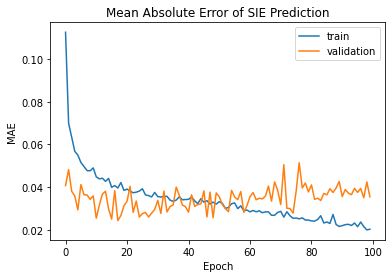

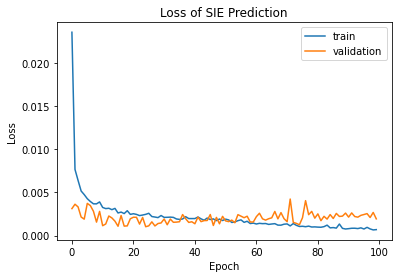

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 3ms/step


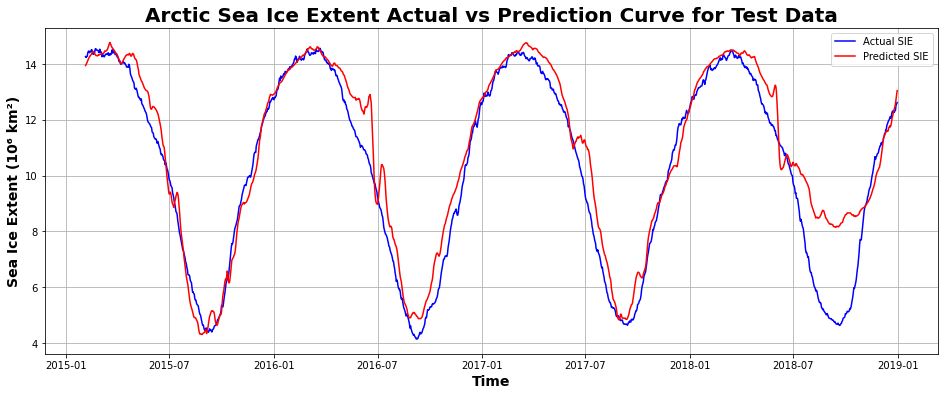

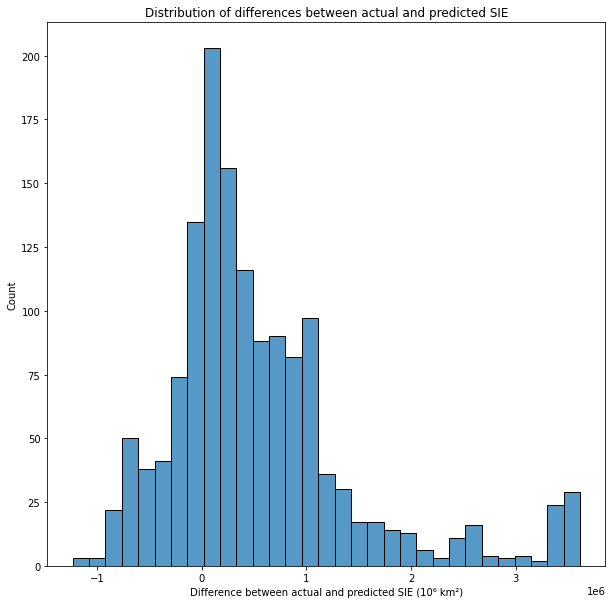

MSE :  1121384925241.4697 (10⁶ km²)
MSPE : 3.0925897827923126 %
RMSE :  1058954.6379526698 (10⁶ km²)
RMSPE : 17.5857606682006 %
MAE :  708281.052908199 (10⁶ km²)
MAPE :  7.683250121645903 %
R2 :  0.8865772244128489


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
# while True:pass